In [1]:
import matplotlib.pyplot as plt
import numpy as np
from arch import arch_model
from scipy.stats import poisson, t, pareto, skewnorm, lognorm, beta, gamma, expon


class BaseModel:
    def __init__(self, params):
        self.params = params

    def next_step(self, current_state):
        raise NotImplementedError("Must be implemented by the subclass.")

    def run_simulation(self, initial_state, steps):
        result = [initial_state]
        for _ in range(steps):
            result.append(self.next_step(result[-1]))
        return result


class DistributionModel:
    def __init__(self, distribution_type, **params):
        self.distribution_type = distribution_type
        self.params = params

    def generate_sample(self):
        if self.distribution_type == 'uniform':
            return np.random.uniform(-1, 1)
        elif self.distribution_type == 'normal':
            return np.random.normal(self.params['mu'], self.params['sigma'])
        elif self.distribution_type == 'poisson':
            return poisson.rvs(self.params['lambda'])
        elif self.distribution_type == 'students':
            return t.rvs(self.params['df'], loc=self.params['mu'], scale=self.params['sigma'])
        elif self.distribution_type == 'pareto':
            return pareto.rvs(self.params['b'])
        elif self.distribution_type == 'skewed_t':
            return skewnorm.rvs(self.params['a'], loc=self.params['mu'], scale=self.params['sigma'])
        elif self.distribution_type == 'log_normal':
            return lognorm.rvs(self.params['s'], scale=np.exp(self.params['mu']))
        elif self.distribution_type == 'beta':
            return beta.rvs(self.params['a'], self.params['b'])
        elif self.distribution_type == 'gamma':
            return gamma.rvs(self.params['a'])
        elif self.distribution_type == 'exponential':
            return expon.rvs(scale=1/self.params['lambda'])
        else:
            raise ValueError("Invalid distribution type")
# Example: Creating a normal distribution model
class AR1Model(BaseModel):
    def next_step(self, current_state):
        alpha, beta = self.params['alpha'], self.params['beta']
        noise = np.random.normal()
        return alpha * current_state + beta + noise
class RandomWalkModel(BaseModel):
    def next_step(self, current_state):
        step_size = np.random.normal()
        return current_state + step_size
class TrendWithNoiseModel(BaseModel):
    def next_step(self, current_state):
        trend, noise_scale = self.params['trend'], self.params['noise_scale']
        noise = np.random.normal(scale=noise_scale)
        return current_state + trend + noise
class CompositeModel(BaseModel):
    def __init__(self, ar1_model, trend_model, random_walk_model):
        self.ar1_model = ar1_model
        self.trend_model = trend_model
        self.random_walk_model = random_walk_model

    def next_step(self, current_state):
        ar1_next = self.ar1_model.next_step(current_state)
        trend_next = self.trend_model.next_step(current_state)
        random_walk_next = self.random_walk_model.next_step(current_state)
        
        return ar1_next + trend_next - random_walk_next



class EnhancedPlottingModel:
    def __init__(self, model, initial_state, steps):
        self.model = model
        self.initial_state = initial_state
        self.steps = steps
        self.simulation_data = []

    def run_simulations(self, num_runs):
        for _ in range(num_runs):
            result = self.model.run_simulation(self.initial_state, self.steps)
            self.simulation_data.append(result)

    def compute_statistics(self):
        self.simulation_data = np.array(self.simulation_data)
        self.mean_process = np.mean(self.simulation_data, axis=0)
        self.median_process = np.median(self.simulation_data, axis=0)
        self.lower_bound = np.percentile(self.simulation_data, 2.5, axis=0)
        self.upper_bound = np.percentile(self.simulation_data, 97.5, axis=0)

    def plot_mean_with_confidence_bands(self):
        plt.fill_between(range(self.steps + 1), self.lower_bound, self.upper_bound, color='gray', alpha=0.5)
        plt.plot(self.mean_process, label='Mean Process', color='blue')
        plt.title('Mean of the Process with 95% Confidence Bands')
        plt.xlabel('Time Step')
        plt.ylabel('Value')
        plt.legend()
        plt.show()

    def plot_representative_median(self):
        # Find the run that is closest to the median at the final step
        final_medians = self.simulation_data[:, -1]
        median_run_index = np.abs(final_medians - self.median_process[-1]).argmin()
        plt.plot(self.simulation_data[median_run_index], label='Representative Median Run', color='green')
        plt.title('Representative Median of the Process Over Time')
        plt.xlabel('Time Step')
        plt.ylabel('Value')
        plt.legend()
        plt.show()
import numpy as np

normal_model = DistributionModel('normal', mu=0, sigma=1)

# Generating a sample
sample = normal_model.generate_sample()

class DriftComponent:
    def __init__(self, drift_rate):
        self.drift_rate = drift_rate

    def value_at(self, time_step, delta_t):
        return time_step * self.drift_rate * delta_t
class WienerProcess:
    def __init__(self, scale=1.0, distribution_model=None):
        self.scale = scale
        self.distribution_model = distribution_model or DistributionModel('normal')

    def value_at(self, steps, delta_t):
        normal_samples = np.array([self.distribution_model.generate_sample() for _ in range(steps)])
        return self.scale * np.cumsum(normal_samples * np.sqrt(delta_t))
class ARCHComponent:
    def __init__(self, alpha0, alpha1):
        self.alpha0 = alpha0
        self.alpha1 = alpha1
        self.distribution_model = DistributionModel('normal')

    def generate_series(self, steps):
        arch_series = [self.distribution_model.generate_sample()]
        for _ in range(1, steps):
            sigma_t = np.sqrt(self.alpha0 + self.alpha1 * arch_series[-1]**2)
            arch_series.append(sigma_t * self.distribution_model.generate_sample())
        return arch_series
class MarkovChain:
    def __init__(self, states, transition_matrix):
        self.states = states
        self.transition_matrix = transition_matrix

    def generate_series(self, steps):
        current_state = np.random.choice(self.states)
        chain = [current_state]
        for _ in range(1, steps):
            current_state = np.random.choice(self.states, p=self.transition_matrix[current_state])
            chain.append(current_state)
        return chain
class MeanReversionComponent:
    def __init__(self, mean, speed_of_reversion, volatility, initial_value=0):
        self.mean = mean
        self.speed_of_reversion = speed_of_reversion
        self.volatility = volatility
        self.current_value = initial_value
        self.distribution_model = DistributionModel('normal')

    def next_value(self, delta_t):
        diff = self.mean - self.current_value
        shock = self.volatility * self.distribution_model.generate_sample()
        self.current_value += self.speed_of_reversion * diff * delta_t + shock * np.sqrt(delta_t)
        return self.current_value

class LevyFlight:
    def __init__(self, alpha):
        self.alpha = alpha

    def step(self):
        direction = np.random.choice([-1, 1])
        length = np.random.pareto(self.alpha)
        return direction * length

    def generate_series(self, steps):
        return np.cumsum([self.step() for _ in range(steps)])
class BubbleProcess:
    def __init__(self, growth_rate, crash_prob):
        self.growth_rate = growth_rate
        self.crash_prob = crash_prob
        self.value = 1

    def step(self):
        if np.random.rand() < self.crash_prob:
            self.value /= 2  # Example crash effect
        else:
            self.value *= self.growth_rate
        return self.value

    def generate_series(self, steps):
        return [self.step() for _ in range(steps)]
class BoundedRandomWalk:
    def __init__(self, distribution_model, start, upper_bound, lower_bound):
        """
        Initialize the bounded random walk.
        :param distribution_model: An instance of DistributionModel for step generation.
        :param start: Starting value of the walk.
        :param upper_bound: Upper bound of the walk.
        :param lower_bound: Lower bound of the walk.
        """
        self.distribution_model = distribution_model
        self.start = start
        self.upper_bound = upper_bound
        self.lower_bound = lower_bound

    def generate_walk(self, steps):
        """
        Generate the bounded random walk.
        :param steps: Number of steps in the walk.
        :return: A list of values in the random walk.
        """
        current_position = self.start
        walk = [current_position]

        for _ in range(steps):
            step = self.distribution_model.generate_sample()
            next_position = current_position + step

            # Check and handle bounds
            if next_position > self.upper_bound:
                next_position = self.upper_bound - (next_position - self.upper_bound)
            elif next_position < self.lower_bound:
                next_position = self.lower_bound + (self.lower_bound - next_position)

            walk.append(next_position)
            current_position = next_position

        return walk

class CyclicProcess:
    def __init__(self, amplitude, frequency):
        self.amplitude = amplitude
        self.frequency = frequency

    def value_at(self, time):
        return self.amplitude * np.sin(self.frequency * time)
class JumpDiffusion:
    def __init__(self, drift, volatility, jump_intensity, jump_mean, jump_std):
        self.drift = drift
        self.volatility = volatility
        self.jump_intensity = jump_intensity
        self.jump_mean = jump_mean
        self.jump_std = jump_std
        self.normal_dist = DistributionModel('normal')

    def step(self, delta_t):
        normal_step = self.drift * delta_t + self.volatility * self.normal_dist.generate_sample() * np.sqrt(delta_t)
        jump = 0
        if np.random.rand() < self.jump_intensity * delta_t:
            jump = np.random.normal(self.jump_mean, self.jump_std)
        return normal_step + jump
class FractionalBrownianMotion:
    def __init__(self, hurst, length):
        self.hurst = hurst
        self.length = length

    def generate_series(self):
        # Implementation of fractional Brownian motion is non-trivial and requires
        # specialized numerical methods.
        pass
class RegimeSwitching:
    def __init__(self, regimes, transition_matrix):
        self.regimes = regimes
        self.transition_matrix = transition_matrix

    def generate_series(self, steps):
        # Implementation requires simulating state transitions and applying the
        # corresponding regime's process at each step.
        pass
class OrnsteinUhlenbeckProcess:
    def __init__(self, mean, speed, vol):
        self.mean = mean
        self.speed = speed
        self.vol = vol

    def step(self, current, delta_t):
        dx = self.speed * (self.mean - current) * delta_t
        dv = self.vol * np.random.normal() * np.sqrt(delta_t)
        return current + dx + dv
class TimeChangedBrownianMotion:
    def __init__(self, time_change_process):
        self.time_change_process = time_change_process
        self.brownian_motion = WienerProcess()

    def generate_series(self, steps):
        # Use the time change process to modify the time parameter in Brownian motion.
        pass
class MultifactorModel:
    def __init__(self, factors):
        self.factors = factors

    def generate_series(self, steps):
        factor_series = [factor.generate_series(steps) for factor in self.factors]
        # Combine these series according to the model's logic
        pass
class ARProcess:
    def __init__(self, coefficients, noise_std):
        self.coefficients = coefficients  # List of AR coefficients
        self.noise_std = noise_std

    def generate_series(self, steps, initial_values):
        series = list(initial_values)
        for t in range(len(initial_values), steps):
            value = sum(coeff * series[t - lag - 1] for lag, coeff in enumerate(self.coefficients))
            value += np.random.normal(scale=self.noise_std)
            series.append(value)
        return series
class ARMAProcess:
    def __init__(self, ar_coefficients, ma_coefficients, noise_std):
        self.ar_coefficients = ar_coefficients
        self.ma_coefficients = ma_coefficients
        self.noise_std = noise_std
        self.noise_terms = []

    def generate_series(self, steps, initial_values):
        series = list(initial_values)
        for t in range(len(initial_values), steps):
            value = sum(self.ar_coefficients[lag] * series[t - lag - 1] for lag in range(len(self.ar_coefficients)))
            value += sum(self.ma_coefficients[lag] * self.noise_terms[t - lag - 1] for lag in range(len(self.ma_coefficients)))
            noise = np.random.normal(scale=self.noise_std)
            self.noise_terms.append(noise)
            value += noise
            series.append(value)
        return series
class ARMAProcess:
    def __init__(self, ar_coefficients, ma_coefficients, noise_std):
        self.ar_coefficients = ar_coefficients
        self.ma_coefficients = ma_coefficients
        self.noise_std = noise_std
        self.noise_terms = []

    def generate_series(self, steps, initial_values):
        series = list(initial_values)
        for t in range(len(initial_values), steps):
            value = sum(self.ar_coefficients[lag] * series[t - lag - 1] for lag in range(len(self.ar_coefficients)))
            value += sum(self.ma_coefficients[lag] * self.noise_terms[t - lag - 1] for lag in range(len(self.ma_coefficients)))
            noise = np.random.normal(scale=self.noise_std)
            self.noise_terms.append(noise)
            value += noise
            series.append(value)
        return series


class GARCHModel:
    def __init__(self, p, q, data, model_type='GARCH', dist='normal'):
        """
        Initialize the GARCH model.
        :param p: Lag order for the ARCH component.
        :param q: Lag order for the GARCH component.
        :param data: Time series data.
        :param model_type: Type of the model ('GARCH', 'TARCH', etc.).
        :param dist: Error distribution ('normal', 't', etc.).
        """
        self.p = p
        self.q = q
        self.data = data
        self.model_type = model_type
        self.dist = dist
        self.model = None

    def fit(self):
        """
        Fit the GARCH model to the data.
        """
        self.model = arch_model(self.data, vol=self.model_type, p=self.p, q=self.q, dist=self.dist)
        return self.model.fit()

    def forecast(self, horizon=1):
        """
        Generate forecasts from the fitted model.
        :param horizon: Number of steps to forecast.
        """
        if self.model is None:
            raise ValueError("Model must be fitted before forecasting.")
        return self.model.forecast(horizon=horizon)


In [5]:
# Parameters
rho = 0.879
tau = 0.15
alpha = 0.6
X = 1
theta = 1
c = 1
gamma = 0.225
a_star = 11.42
z_thilde = 1
Omega = 0.3
L_lower =((1-gamma)/Omega)**(1/(1-alpha))
L_upper = ((1)/Omega)**(1/(1-alpha))


# Initial Values
initial_income = 1.176 # z
initial_population = 0.364 # L
# initial_technology_growth = 0 # a
initial_technology_level = 0.87 # A
initial_education = 0 # e
initial_growth = 0.048 # g
initial_human = 0 # h
initial_fertility

In [9]:
class GalorWeilModel(BaseModel):
    def __init__(self, params, initial_state):
        super().__init__(params)
        self.initial_state = initial_state

    def next_step(self, current_state):
        # Unpack current state variables
        population, income, education, growth, technology_level, technology_growth, human_capital = current_state

        # Unpack parameters
        gamma, tau, alpha, X, theta, c, a_star, z_thilde, Omega, L_lower, L_upper, rho = self.params.values()

        # Update population
        if population <= L_lower:
            population = (gamma / tau) * population
        elif L_lower < population < L_upper:
            population = (1 / tau) * (1 - Omega * (population ** (1 - alpha))) * population
        # If population > L_upper, it remains the same

        # Update other variables
        income = (human_capital ** alpha) * ((technology_level * X) / (population)) ** (1 - alpha)
        education = max(0, ((education[-1] + rho * tau) * technology_growth[-1] * tau * (1 - rho)) ** (0.5) - rho * tau)
        growth = technology_growth * (education + rho * tau)
        technology_level = (1 + growth[-1]) * technology_level[-1]
        technology_growth = min(theta * population[-1], a_star)
        human_capital = (education + rho * tau) / (education + rho * tau + growth)
        
        return population, income, education, growth, technology_level, technology_growth, human_capital

# Example of running the simulation
params = {
    'gamma': gamma, 'tau': tau, 'alpha': alpha, 'X': X, 'theta': theta, 
    'c': c, 'a_star': a_star, 'z_thilde': z_thilde, 'Omega': Omega,
    'L_lower': L_lower, 'L_upper': L_upper, 'rho': rho
}

initial_state = (initial_population, initial_income, initial_education, 
                 initial_growth, initial_technology_level, initial_technology_growth, initial_human)
def plot_simulation_results(model, initial_state, steps):
    # Run the simulation
    simulation_data = model.run_simulation(initial_state, steps)

    # Extracting each variable
    population = [state[0] for state in simulation_data]
    income = [state[1] for state in simulation_data]
    technology_level = [state[4] for state in simulation_data]
    education = [state[2] * 100 for state in simulation_data]  # Multiplying by 100

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(population, label='Population')
    plt.plot(income, label='Income')
    plt.plot(technology_level, label='Technology Level')
    plt.plot(education, label='Education * 100')

    plt.xlabel('Time Steps')
    plt.ylabel('Values')
    plt.title('Galor-Weil Model Simulation')
    plt.legend()
    plt.show()

# Initialize the GalorWeilModel
model = GalorWeilModel(params, initial_state)

# Plot the results
plot_simulation_results(model, initial_state, 100)

TypeError: 'int' object is not subscriptable

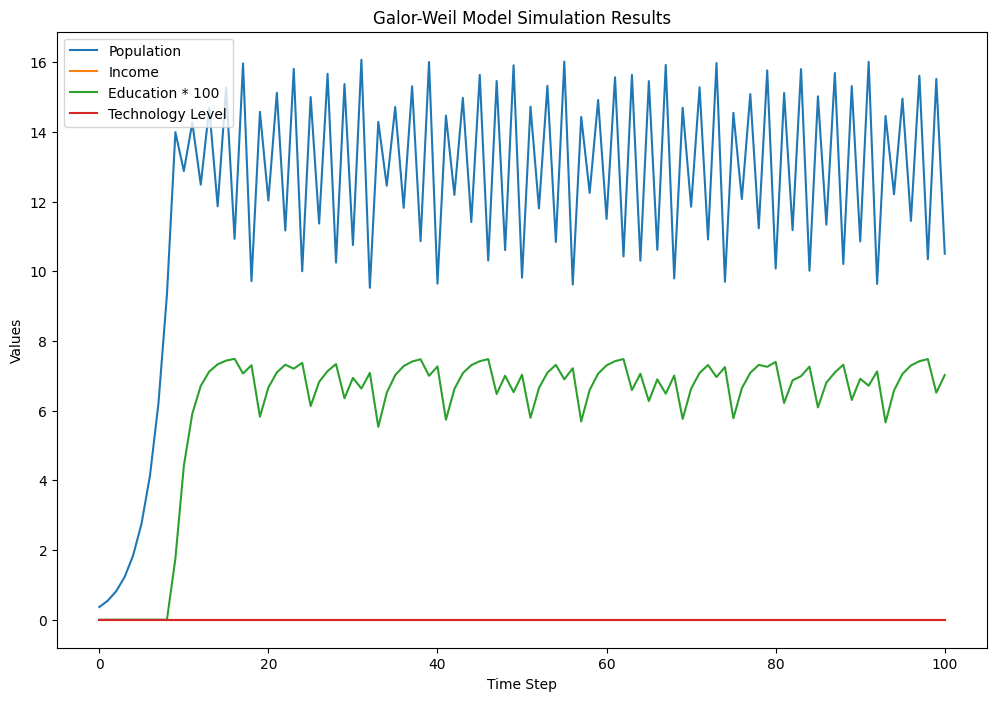

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Redefining the GalorWeilModel with the ability to use past period values
class GalorWeilModel(BaseModel):
    def __init__(self, params, initial_state):
        super().__init__(params)
        self.initial_state = initial_state

    def next_step(self, previous_state):
        # Unpack previous state variables
        prev_population, prev_income, prev_education, prev_growth, prev_technology_level, prev_technology_growth, prev_human_capital = previous_state

        # Unpack parameters
        gamma, tau, alpha, X, theta, c, a_star, z_thilde, Omega, L_lower, L_upper, rho = self.params.values()

        # Calculating population
        if prev_population <= L_lower:
            population = (gamma / tau) * prev_population
        elif L_lower < prev_population < L_upper:
            population = (1 / tau) * (1 - Omega * (prev_population ** (1 - alpha))) * prev_population
        else:
            population = 0 #prev_population

        # Calculating other variables based on previous state
        income = (prev_human_capital ** alpha) * ((prev_technology_level * X) / (population)) ** (1 - alpha)
        education = max(0, ((prev_education + rho * tau) * prev_technology_growth * tau * (1 - rho)) ** (0.5) - rho * tau)
        growth = prev_technology_growth * (prev_education + rho * tau)
        technology_level = (1 + prev_growth) * prev_technology_level
        technology_growth = min(theta * population, a_star)
        human_capital = (education + rho * tau) / (education + rho * tau + growth)

        return population, income, education, growth, technology_level, technology_growth, human_capital

    def run_simulation(self, steps):
        result = [self.initial_state]
        for _ in range(steps):
            result.append(self.next_step(result[-1]))
        return result

# Setting up parameters and initial values for the simulation
params = {
    'gamma': 0.225, 'tau': 0.15, 'alpha': 0.6, 'X': 1, 'theta': 1, 
    'c': 1, 'a_star': 11.42, 'z_thilde': 1, 'Omega': 0.3,
    'L_lower': ((1-0.225)/0.3)**(1/(1-0.6)), 
    'L_upper': (1/0.3)**(1/(1-0.6)), 'rho': 0.879
}
initial_state = (0.364, 0, 0, 0, 0, 0, 0)  # Initial values for population, income, education, etc.

# Creating an instance of the model and running the simulation
galor_weil_model = GalorWeilModel(params, initial_state)
simulation_result = galor_weil_model.run_simulation(100)

# Extracting data for plotting
populations, incomes, educations, growths, technology_levels, technology_growths, human_capitals = zip(*simulation_result)
times = range(len(populations))

# Plotting the results
plt.figure(figsize=(12, 8))
plt.plot(times, populations, label='Population')
plt.plot(times, incomes, label='Income')
plt.plot(times, [e * 100 for e in educations], label='Education * 100')
plt.plot(times, technology_levels, label='Technology Level')

plt.title('Galor-Weil Model Simulation Results')
plt.xlabel('Time Step')
plt.ylabel('Values')
plt.legend()
plt.show()

